## Deep Learning

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import os
#from plotly import plotly
#import plotly.offline as offline
#import plotly.graph_objs as go
#offline.init_notebook_mode()
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Flatten,Reshape
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
import csv
from tensorflow.keras.models import Model
#import keras
from tensorflow.keras import backend as k
from tensorflow.keras.layers import Input,Concatenate,Dropout,Dense,BatchNormalization,Conv1D
from tensorflow.keras.layers import Input
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
#from tensorflow.keras.merge import concatenate
#import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import scipy
from tensorflow.keras.initializers import he_normal,glorot_normal
from tensorflow.keras.regularizers import l1,l2
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint,LearningRateScheduler,ReduceLROnPlateau
from time import time
from tensorflow.keras.utils import plot_model

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import pandas as pd
data=pd.read_csv('/content/gdrive/MyDrive/Case Study-2(Sarcastic Comments-REDDIT)/train-balanced-sarcasm.csv')
data.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [4]:
data.isnull().sum()

label              0
comment           53
author             0
subreddit          0
score              0
ups                0
downs              0
date               0
created_utc        0
parent_comment     0
dtype: int64

In [5]:
data['comment']=data['comment'].fillna('No Comment')

In [6]:
# Remove Emoji
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

In [7]:
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

In [8]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [9]:
from nltk.corpus import stopwords
from tqdm import tqdm
import re
stopwords = stopwords.words('english')
def preprocess(text_col,stopword):
    preprocessed = []
    for sentence in tqdm(text_col.values):
        # Replace "carriage return" with "space".
        sentence=str(sentence)
        sent = sentence.replace('\\r', ' ')
        # Replace "quotes" with "space".
        sent = sent.replace('\\"', ' ')
        # Replace "line feed" with "space".
        sent = sent.replace('\\n', ' ')
        # Replace characters between words with "space".
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        #remove stop words
        #decontraction
        sent=decontractions(sent)
        #Remove emoji
        sent=deEmojify(sent)
        if stopword:
            sent = ' '.join(e for e in sent.split() if e not in stopwords)
        else:
           sent = ' '.join(e for e in sent.split())
        # to lowercase
        preprocessed.append(sent.lower().strip())
    return preprocessed

In [10]:
data['comment']=preprocess(data['comment'],stopword=False)

100%|██████████| 1010826/1010826 [00:27<00:00, 36513.21it/s]


In [11]:
data['parent_comment']=preprocess(data['parent_comment'],stopword=False)

100%|██████████| 1010826/1010826 [00:34<00:00, 29033.92it/s]


In [12]:
data.isnull().sum()

label             0
comment           0
author            0
subreddit         0
score             0
ups               0
downs             0
date              0
created_utc       0
parent_comment    0
dtype: int64

In [13]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

Polarity Score

In [14]:
import nltk
from tqdm import tqdm
from nltk.sentiment.vader import SentimentIntensityAnalyzer
def generate_sentiment_scores(data):
    sid = SentimentIntensityAnalyzer()
    neg=[]
    pos=[]
    neu=[]
    comp=[]
    for sentence in tqdm(data['parent_comment'].values): 
        sentence_sentiment_score = sid.polarity_scores(sentence)
        comp.append(sentence_sentiment_score['compound'])
        neg.append(sentence_sentiment_score['neg'])
        pos.append(sentence_sentiment_score['pos'])
        neu.append(sentence_sentiment_score['neu'])
    return comp,neg,pos,neu

In [15]:
data['compound'],data['negative'],data['positive'],data['neutral']=generate_sentiment_scores(data)

100%|██████████| 1010826/1010826 [04:45<00:00, 3537.94it/s]


In [16]:
data['com_len']=data['comment'].apply(lambda x:len(x.split()))

In [17]:
data['parent_com_len']=data['parent_comment'].apply(lambda x:len(x.split()))

In [18]:
data['comment']=data['comment']+" "+data['author']+" "+data['subreddit']

In [19]:
labels=tf.keras.utils.to_categorical(data['label'].values,num_classes=2)
labels.shape

(1010826, 2)

In [20]:
y=data['label']
X=data.drop(['label','date','created_utc'],axis=1)

In [21]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,labels,test_size=0.3,random_state=42,stratify=labels)

In [22]:
def pad_text(text,tokenizer,max_len):
    return pad_sequences(tokenizer.texts_to_sequences(text),maxlen=max_len,padding='post')

In [23]:
from tensorflow.keras.preprocessing.text import Tokenizer
def text_padding(train,test,max_len):
    vocab=5000
    token=Tokenizer()
    token.fit_on_texts(train)
    padded_train_text=pad_text(train,token,max_len)
    padded_test_text=pad_text(test,token,max_len)
    return padded_train_text,padded_test_text,token

In [24]:
comm_len=200
train_com_pad,test_com_pad,token_com= text_padding(X_train['comment'],X_test['comment'],comm_len)

In [25]:
print(train_com_pad.shape,test_com_pad.shape)

(707578, 200) (303248, 200)


In [26]:
par_comm_len=200
train_par_com_pad,test_par_com_pad,token_par= text_padding(X_train['parent_comment'],X_test['parent_comment'],par_comm_len)

In [27]:
print(train_par_com_pad.shape,test_par_com_pad.shape)

(707578, 200) (303248, 200)


In [28]:
def generate_embedding_matrix(token):
    embedding_path='/content/gdrive/MyDrive/Case Study-2(Sarcastic Comments-REDDIT)/glove.42B.300d.txt'
    embedding_dimension=300
    embedding_index={}
    with open(embedding_path) as f:
         for line in f:
             values=line.split()
             word=values[0]
             coefs=np.asarray(values[1:],dtype='float32')
             embedding_index[word]=coefs
    f.close()        
    embedding_matrix=np.zeros((len(token.word_index)+1,embedding_dimension))
    num_words_in_embedding = 0
    for word, i in token.word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
           embedding_matrix[i] = embedding_vector
        #print("embedding matrix shape",embedding_matrix.shape)
    return embedding_matrix

In [29]:
embedding_comm = generate_embedding_matrix(token_com)
embedding_P_comm = generate_embedding_matrix(token_par)
print(embedding_comm.shape,embedding_P_comm.shape)

(362500, 300) (189737, 300)


In [30]:
%%time
from sklearn.preprocessing import Normalizer
trans = Normalizer()
X_train_score=trans.fit_transform(X_train['score'].values.reshape(-1,1))
X_test_score=trans.transform(X_test['score'].values.reshape(-1,1))

CPU times: user 12.6 ms, sys: 2.96 ms, total: 15.5 ms
Wall time: 15 ms


In [31]:
%%time
trans = Normalizer()
X_train_ups=trans.fit_transform(X_train['ups'].values.reshape(-1,1))
X_test_ups=trans.transform(X_test['ups'].values.reshape(-1,1))

CPU times: user 12.9 ms, sys: 0 ns, total: 12.9 ms
Wall time: 12.9 ms


In [32]:
%%time
trans = Normalizer()
X_train_downs=trans.fit_transform(X_train['downs'].values.reshape(-1,1))
X_test_downs=trans.transform(X_test['downs'].values.reshape(-1,1))

CPU times: user 14.4 ms, sys: 947 µs, total: 15.4 ms
Wall time: 14.7 ms


In [33]:
%%time
trans = Normalizer()
X_train_comp=trans.fit_transform(X_train['compound'].values.reshape(-1,1))
X_test_comp=trans.transform(X_test['compound'].values.reshape(-1,1))

CPU times: user 19.8 ms, sys: 0 ns, total: 19.8 ms
Wall time: 19.2 ms


In [34]:
%%time
trans = Normalizer()
X_train_neg=trans.fit_transform(X_train['negative'].values.reshape(-1,1))
X_test_neg=trans.transform(X_test['negative'].values.reshape(-1,1))

CPU times: user 20 ms, sys: 34 µs, total: 20.1 ms
Wall time: 19.5 ms


In [35]:
%%time
trans = Normalizer()
X_train_pos=trans.fit_transform(X_train['positive'].values.reshape(-1,1))
X_test_pos=trans.transform(X_test['positive'].values.reshape(-1,1))

CPU times: user 19.8 ms, sys: 0 ns, total: 19.8 ms
Wall time: 19.2 ms


In [36]:
%%time
trans = Normalizer()
X_train_neu=trans.fit_transform(X_train['neutral'].values.reshape(-1,1))
X_test_neu=trans.transform(X_test['neutral'].values.reshape(-1,1))

CPU times: user 14.9 ms, sys: 6 µs, total: 14.9 ms
Wall time: 14.2 ms


In [37]:
%%time
trans = Normalizer()
X_train_com_len=trans.fit_transform(X_train['com_len'].values.reshape(-1,1))
X_test_com_len=trans.transform(X_test['com_len'].values.reshape(-1,1))

CPU times: user 13.4 ms, sys: 945 µs, total: 14.3 ms
Wall time: 13.6 ms


In [38]:
%%time
trans = Normalizer()
X_train_parent_com_len=trans.fit_transform(X_train['parent_com_len'].values.reshape(-1,1))
X_test_parent_com_len=trans.transform(X_test['parent_com_len'].values.reshape(-1,1))

CPU times: user 13.9 ms, sys: 29 µs, total: 13.9 ms
Wall time: 12.9 ms


In [39]:
numerical_train=np.concatenate((X_train_score,X_train_ups,X_train_downs,X_train_comp,X_train_neu,X_train_neg,X_train_pos,X_train_com_len,X_train_parent_com_len),axis=1)
numerical_test=np.concatenate((X_test_score,X_test_ups,X_test_downs,X_test_comp,X_test_neu,X_test_neg,X_test_pos,X_test_com_len,X_test_parent_com_len),axis=1)

In [40]:
print(numerical_train.shape,numerical_test.shape)

(707578, 9) (303248, 9)


In [41]:
X_train=[train_com_pad,train_par_com_pad,numerical_train]
X_test=[test_com_pad,test_par_com_pad,numerical_test]

# **Model:-1**

LSTM layer Using Pre-Trained GloVe Embedding

In [47]:
from tensorflow.keras.layers import concatenate
def LSTM_Model1(comm_len,token_com,par_comm_len,token_par,embedding_comm,embedding_P_comm):
    drop_lstm = 0.25
    drop_dense = 0.25
    num_lstm=150
  
    input_text_1=Input(shape=(comm_len,), name='Comment', dtype='float32')
    sequence_input_1=Embedding(len(token_com.word_index) + 1,300,weights=[embedding_comm],input_length=comm_len,trainable=False,dtype=tf.float32)(input_text_1)
    sequence_input_1=LSTM(num_lstm,dropout=drop_lstm,return_sequences=True,dtype=tf.float32)(sequence_input_1)
    sequence_input_1=Flatten()(sequence_input_1)
    
    input_text_2=Input(shape=(par_comm_len,),name='parent_comment', dtype='float32')
    sequence_input_2=Embedding(len(token_par.word_index) + 1,300,weights=[embedding_P_comm],input_length=par_comm_len,trainable=False,dtype=tf.float32)(input_text_2)
    sequence_input_2=LSTM(num_lstm,dropout=drop_lstm,return_sequences=True,dtype=tf.float32)(sequence_input_2)
    sequence_input_2=Flatten()(sequence_input_2)
    
    
    input5 = Input(shape=(9,),name='Numerical', dtype='float32')
    flatten_6 = Dense(32,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001),dtype=tf.float32)(input5)
    flatten_6 = Dense(16,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001),dtype=tf.float32)(flatten_6)
    concat=concatenate([sequence_input_1,sequence_input_2,flatten_6],dtype=tf.float32)
  
    y = Dense(128,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(concat)
    y = BatchNormalization()(y)
    y = Dense(64,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(y)
    y = BatchNormalization()(y)
    y = Dense(32,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(y)
  
    final_output=Dense(2,activation='softmax')(y)
  
    model= Model(inputs=[input_text_1,input_text_2,input5],outputs=final_output)
    return model

In [48]:
model4=LSTM_Model1(comm_len,token_com,par_comm_len,token_par,embedding_comm,embedding_P_comm)
model4.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Comment (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
parent_comment (InputLayer)     [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 300)     108750000   Comment[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 300)     56921100    parent_comment[0][0]             
______________________________________________________________________________________________

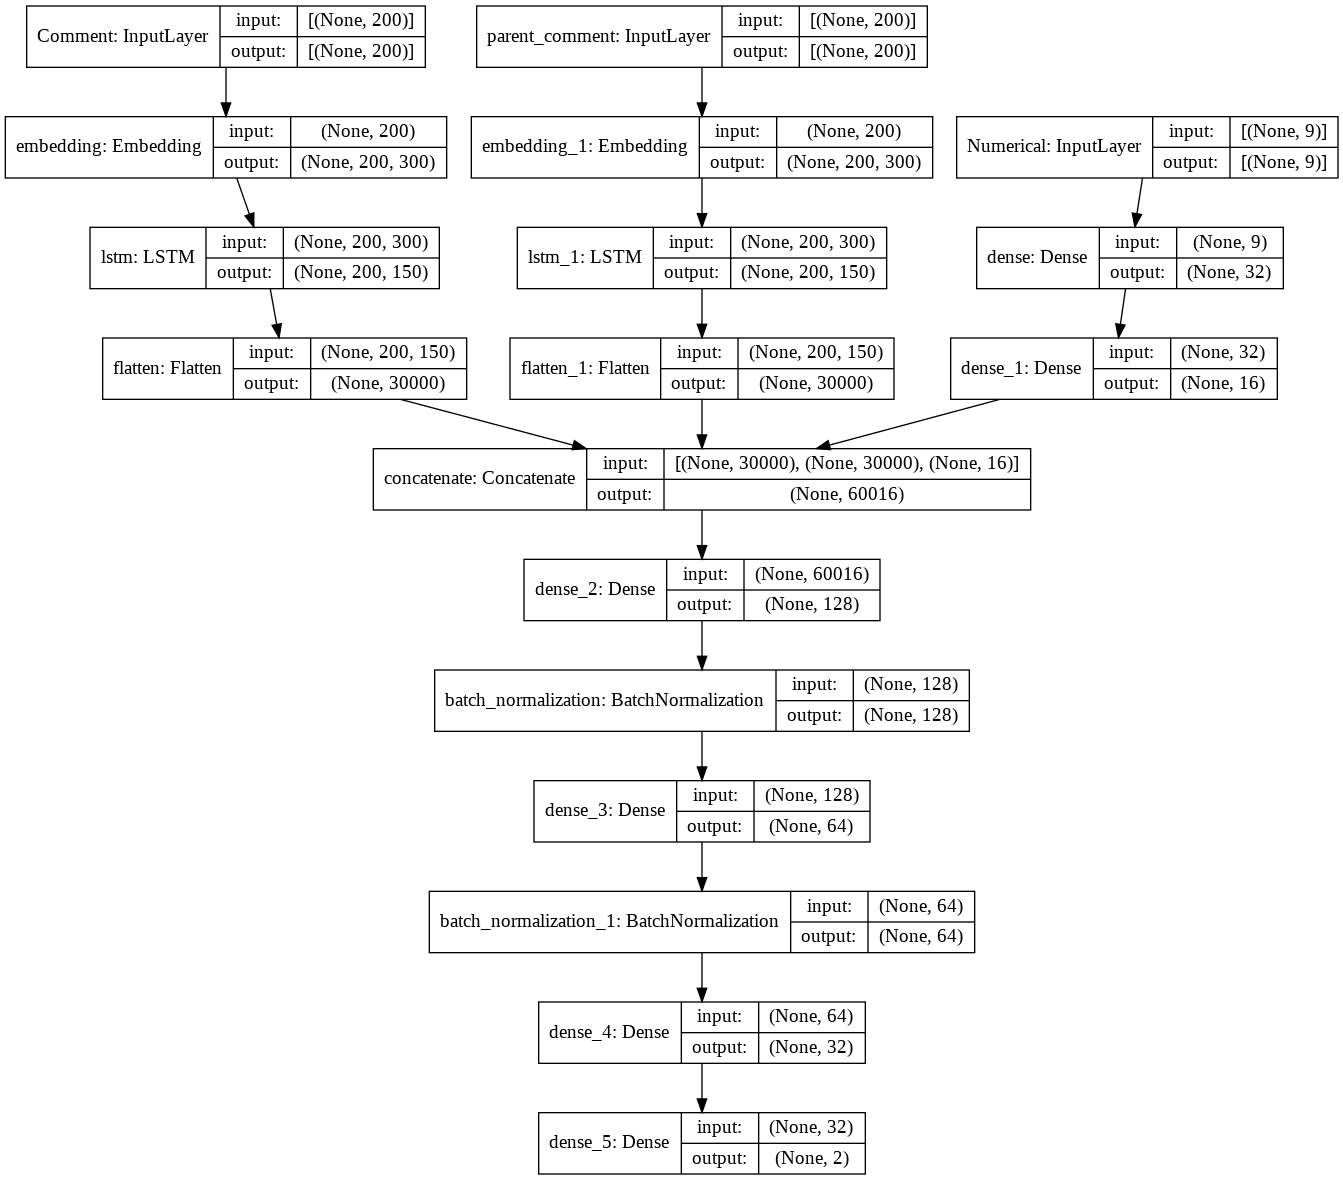

In [49]:
tf.keras.utils.plot_model(
    model4, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB')

In [50]:
from tensorflow.keras.callbacks import *
import os
filepath="weights_4.best.hdf1"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, mode='max')
earlystop = EarlyStopping(monitor = 'val_accuracy',  mode="max",min_delta = 0, patience = 3,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.25, patience = 2, verbose = 1)
%reload_ext tensorboard
import datetime
logdir = os.path.join("logs_4", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
tensorboard = TensorBoard(log_dir=logdir, histogram_freq=0, write_graph=True, write_grads=False, write_images=False)
callbacks = [checkpoint,reduce_lr,tensorboard,earlystop]

In [51]:
import tensorflow as tf
adam = tf.keras.optimizers.Adam(lr=0.01)
model4.compile(optimizer=adam, loss='categorical_crossentropy',metrics=['accuracy'])

In [52]:
hitory4=model4.fit(x=X_train,y=y_train,epochs=50,batch_size=512,validation_data=(X_test, y_test),callbacks=callbacks)

Epoch 1/50
1382/1382 [==============================] - 178s 124ms/step - loss: 1.9756 - accuracy: 0.6727 - val_loss: 16.5944 - val_accuracy: 0.5000

Epoch 00001: saving model to weights_4.best.hdf1


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets


Epoch 2/50
1382/1382 [==============================] - 171s 123ms/step - loss: 1.3068 - accuracy: 0.7053 - val_loss: 1.0621 - val_accuracy: 0.5966

Epoch 00002: saving model to weights_4.best.hdf1


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets


Epoch 3/50
1382/1382 [==============================] - 171s 124ms/step - loss: 1.1151 - accuracy: 0.7102 - val_loss: 9.6105 - val_accuracy: 0.5000

Epoch 00003: saving model to weights_4.best.hdf1


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets


Epoch 4/50
1382/1382 [==============================] - 171s 124ms/step - loss: 0.9734 - accuracy: 0.7181 - val_loss: 1.2508 - val_accuracy: 0.5049

Epoch 00004: saving model to weights_4.best.hdf1


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets



Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
Epoch 5/50
1382/1382 [==============================] - 171s 124ms/step - loss: 0.5832 - accuracy: 0.7312 - val_loss: 0.5668 - val_accuracy: 0.7304

Epoch 00005: saving model to weights_4.best.hdf1


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets


Epoch 6/50
1382/1382 [==============================] - 171s 124ms/step - loss: 0.5564 - accuracy: 0.7356 - val_loss: 0.9176 - val_accuracy: 0.6524

Epoch 00006: saving model to weights_4.best.hdf1


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets


Epoch 7/50
1382/1382 [==============================] - 171s 124ms/step - loss: 0.5614 - accuracy: 0.7393 - val_loss: 0.9060 - val_accuracy: 0.5430

Epoch 00007: saving model to weights_4.best.hdf1


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets



Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.
Epoch 8/50
1382/1382 [==============================] - 171s 124ms/step - loss: 0.5230 - accuracy: 0.7452 - val_loss: 0.5524 - val_accuracy: 0.7285

Epoch 00008: saving model to weights_4.best.hdf1


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_4.best.hdf1/assets


Epoch 00008: early stopping


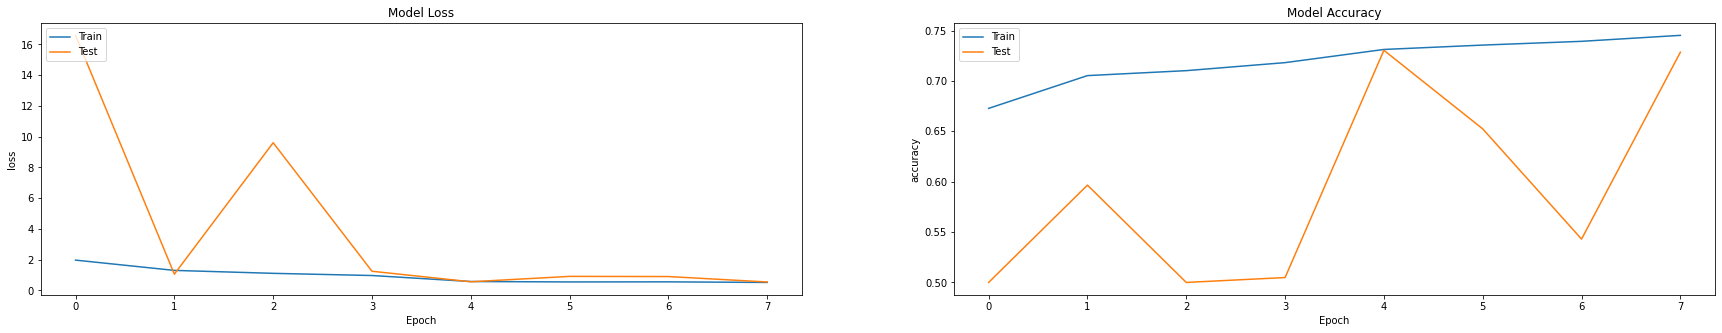

In [53]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(hitory4.history['loss'])
plt.plot(hitory4.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation f1_score
plt.subplot(122)
plt.plot(hitory4.history['accuracy'])
plt.plot(hitory4.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# **Model:-2**

In [61]:
from tensorflow.keras.layers import concatenate
def LSTM_Model2(comm_len,token_com,par_comm_len,token_par,embedding_comm,embedding_P_comm):
    drop_lstm = 0.25
    drop_dense = 0.25
    num_lstm=150
  
    input_text_1=Input(shape=(comm_len,), name='Comment', dtype='float32')
    sequence_input_1=Embedding(len(token_com.word_index) + 1,300,weights=[embedding_comm],input_length=comm_len,trainable=False,dtype=tf.float32)(input_text_1)
    sequence_input_1=LSTM(num_lstm,dropout=drop_lstm,return_sequences=True,dtype=tf.float32)(sequence_input_1)
    sequence_input_1=Flatten()(sequence_input_1)
    
    input_text_2=Input(shape=(par_comm_len,),name='parent_comment', dtype='float32')
    sequence_input_2=Embedding(len(token_par.word_index) + 1,300,weights=[embedding_P_comm],input_length=par_comm_len,trainable=False,dtype=tf.float32)(input_text_2)
    sequence_input_2=LSTM(num_lstm,dropout=drop_lstm,return_sequences=True,dtype=tf.float32)(sequence_input_2)
    sequence_input_2=Flatten()(sequence_input_2)
    
    
    input5 = Input(shape=(9,),name='Numerical', dtype='float32')
    flatten_6 = Dense(32,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001),dtype=tf.float32)(input5)
    flatten_6 = Dense(16,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001),dtype=tf.float32)(flatten_6)
    concat=concatenate([sequence_input_1,sequence_input_2,flatten_6],dtype=tf.float32)
  
    y = Dense(2048,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(concat)
    y = BatchNormalization()(y)
    y=Dropout(0.60)(y)
    y = Dense(1024,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(y)
    y = BatchNormalization()(y)
    y=Dropout(0.40)(y)
    y = Dense(512,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(y)
    y = BatchNormalization()(y)
    y=Dropout(0.30)(y)
    y = Dense(128,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(y)
    y = BatchNormalization()(y)
    y=Dropout(0.20)(y)
    final_output=Dense(2,activation='softmax')(y)
  
    model= Model(inputs=[input_text_1,input_text_2,input5],outputs=final_output)
    return model

In [62]:
model2=LSTM_Model2(comm_len,token_com,par_comm_len,token_par,embedding_comm,embedding_P_comm)
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Comment (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
parent_comment (InputLayer)     [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 200, 300)     108750000   Comment[0][0]                    
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 200, 300)     56921100    parent_comment[0][0]             
____________________________________________________________________________________________

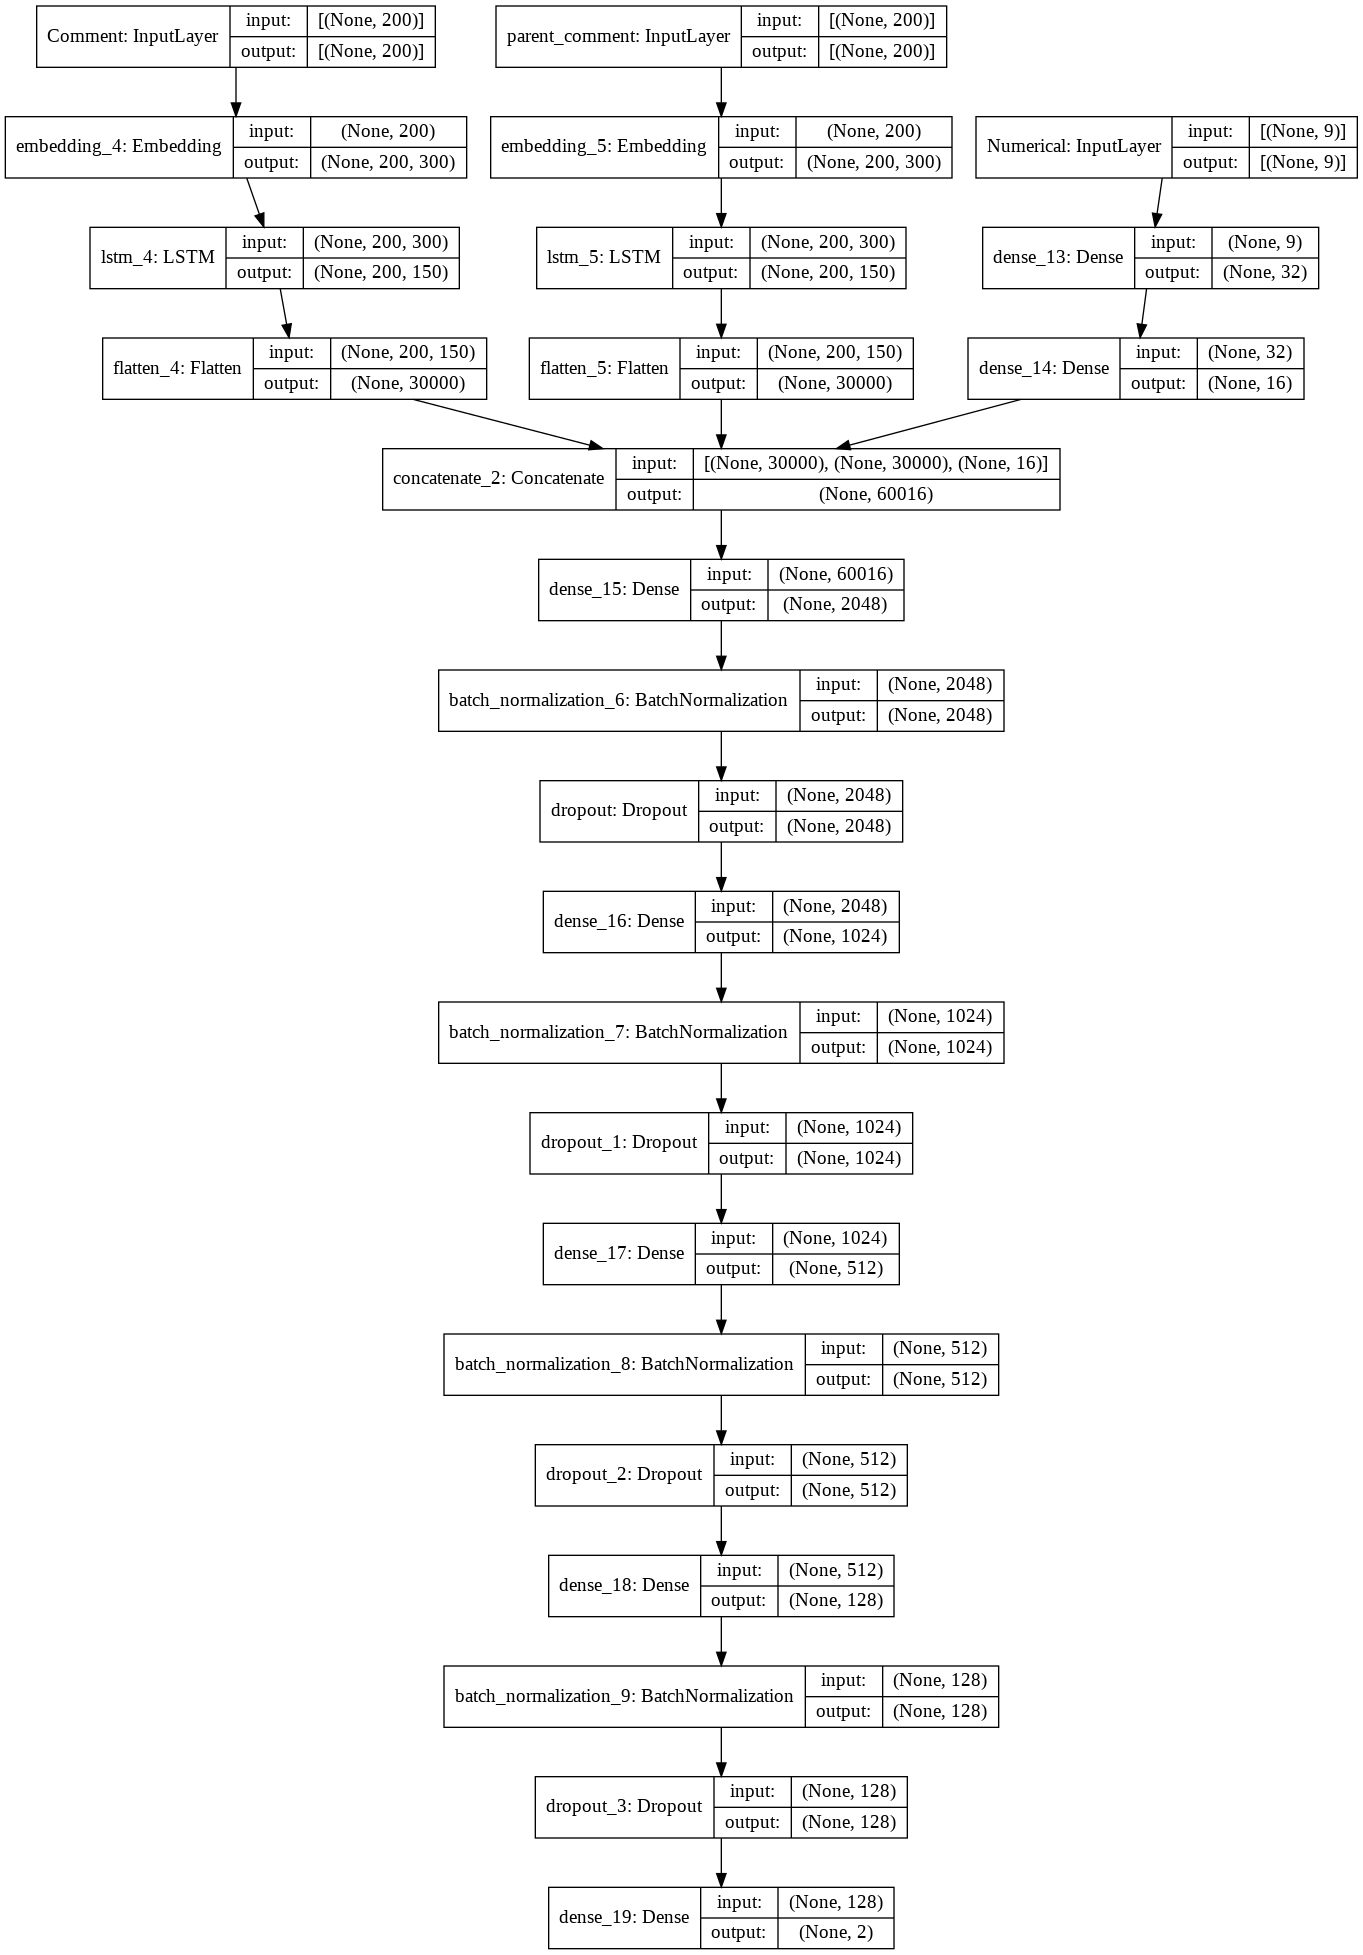

In [63]:
tf.keras.utils.plot_model(
    model2, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB')

In [64]:
from tensorflow.keras.callbacks import *
import os
filepath="weights_2.best.hdf1"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, mode='max')
earlystop = EarlyStopping(monitor = 'val_accuracy',  mode="max",min_delta = 0, patience = 3,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.25, patience = 2, verbose = 1)
%reload_ext tensorboard
import datetime
logdir = os.path.join("logs_2", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
tensorboard = TensorBoard(log_dir=logdir, histogram_freq=0, write_graph=True, write_grads=False, write_images=False)
callbacks = [checkpoint,reduce_lr,tensorboard,earlystop]

In [65]:
import tensorflow as tf
adam = tf.keras.optimizers.Adam(lr=0.01)
model2.compile(optimizer=adam, loss='categorical_crossentropy',metrics=['accuracy'])

In [66]:
hitory2=model2.fit(x=X_train,y=y_train,epochs=50,batch_size=512,validation_data=(X_test, y_test),callbacks=callbacks)

Epoch 1/50
1382/1382 [==============================] - 273s 194ms/step - loss: 7.6985 - accuracy: 0.6650 - val_loss: 45.5718 - val_accuracy: 0.5000

Epoch 00001: saving model to weights_2.best.hdf1


INFO:tensorflow:Assets written to: weights_2.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_2.best.hdf1/assets


Epoch 2/50
1382/1382 [==============================] - 267s 193ms/step - loss: 4.1002 - accuracy: 0.7042 - val_loss: 3.6235 - val_accuracy: 0.6835

Epoch 00002: saving model to weights_2.best.hdf1


INFO:tensorflow:Assets written to: weights_2.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_2.best.hdf1/assets


Epoch 3/50
1382/1382 [==============================] - 267s 193ms/step - loss: 4.0102 - accuracy: 0.7121 - val_loss: 11.6839 - val_accuracy: 0.5000

Epoch 00003: saving model to weights_2.best.hdf1


INFO:tensorflow:Assets written to: weights_2.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_2.best.hdf1/assets


Epoch 4/50
1382/1382 [==============================] - 267s 193ms/step - loss: 3.5058 - accuracy: 0.7169 - val_loss: 3.4139 - val_accuracy: 0.7240

Epoch 00004: saving model to weights_2.best.hdf1


INFO:tensorflow:Assets written to: weights_2.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_2.best.hdf1/assets


Epoch 5/50
1382/1382 [==============================] - 267s 193ms/step - loss: 3.6396 - accuracy: 0.7199 - val_loss: 3.9546 - val_accuracy: 0.7239

Epoch 00005: saving model to weights_2.best.hdf1


INFO:tensorflow:Assets written to: weights_2.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_2.best.hdf1/assets


Epoch 6/50
1382/1382 [==============================] - 267s 194ms/step - loss: 3.1523 - accuracy: 0.7220 - val_loss: 3.7970 - val_accuracy: 0.5000

Epoch 00006: saving model to weights_2.best.hdf1


INFO:tensorflow:Assets written to: weights_2.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_2.best.hdf1/assets



Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
Epoch 7/50
1382/1382 [==============================] - 267s 193ms/step - loss: 1.2004 - accuracy: 0.7323 - val_loss: 6.5436 - val_accuracy: 0.5002

Epoch 00007: saving model to weights_2.best.hdf1


INFO:tensorflow:Assets written to: weights_2.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_2.best.hdf1/assets


Epoch 00007: early stopping


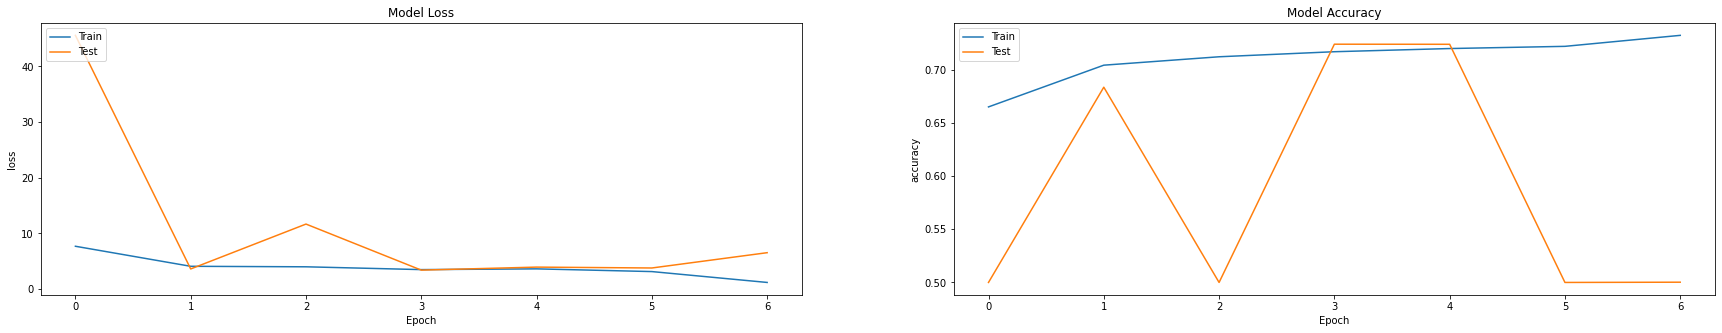

In [67]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(hitory2.history['loss'])
plt.plot(hitory2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation f1_score
plt.subplot(122)
plt.plot(hitory2.history['accuracy'])
plt.plot(hitory2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# **Model:-3**

In [68]:
from tensorflow.keras.layers import concatenate
def LSTM_Model3(comm_len,token_com,par_comm_len,token_par,embedding_comm,embedding_P_comm):
    drop_lstm = 0.25
    drop_dense = 0.25
    num_lstm=150
  
    input_text_1=Input(shape=(comm_len,), name='Comment', dtype='float32')
    sequence_input_1=Embedding(len(token_com.word_index) + 1,300,weights=[embedding_comm],input_length=comm_len,trainable=False,dtype=tf.float32)(input_text_1)
    sequence_input_1=LSTM(num_lstm,dropout=drop_lstm,return_sequences=True,dtype=tf.float32)(sequence_input_1)
    sequence_input_1=Flatten()(sequence_input_1)
    
    input_text_2=Input(shape=(par_comm_len,),name='parent_comment', dtype='float32')
    sequence_input_2=Embedding(len(token_par.word_index) + 1,300,weights=[embedding_P_comm],input_length=par_comm_len,trainable=False,dtype=tf.float32)(input_text_2)
    sequence_input_2=LSTM(num_lstm,dropout=drop_lstm,return_sequences=True,dtype=tf.float32)(sequence_input_2)
    sequence_input_2=Flatten()(sequence_input_2)
    
    
    input5 = Input(shape=(9,),name='Numerical', dtype='float32')
    flatten_6 = Dense(32,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001),dtype=tf.float32)(input5)
    flatten_6 = Dense(16,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001),dtype=tf.float32)(flatten_6)
    concat=concatenate([sequence_input_1,sequence_input_2,flatten_6],dtype=tf.float32)
    y = Dense(4096,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(concat)
    y = BatchNormalization()(y)
    y=Dropout(0.60)(y)
    y = Dense(2048,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(concat)
    y = BatchNormalization()(y)
    y=Dropout(0.60)(y)
    y = Dense(1024,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(y)
    y = BatchNormalization()(y)
    y=Dropout(0.40)(y)
    y = Dense(512,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(y)
    y = BatchNormalization()(y)
    y=Dropout(0.30)(y)
    y = Dense(128,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(y)
    y = BatchNormalization()(y)
    y=Dropout(0.20)(y)
    final_output=Dense(2,activation='softmax')(y)
  
    model= Model(inputs=[input_text_1,input_text_2,input5],outputs=final_output)
    return model

In [69]:
model3=LSTM_Model3(comm_len,token_com,par_comm_len,token_par,embedding_comm,embedding_P_comm)
model3.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Comment (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
parent_comment (InputLayer)     [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 200, 300)     108750000   Comment[0][0]                    
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 200, 300)     56921100    parent_comment[0][0]             
____________________________________________________________________________________________

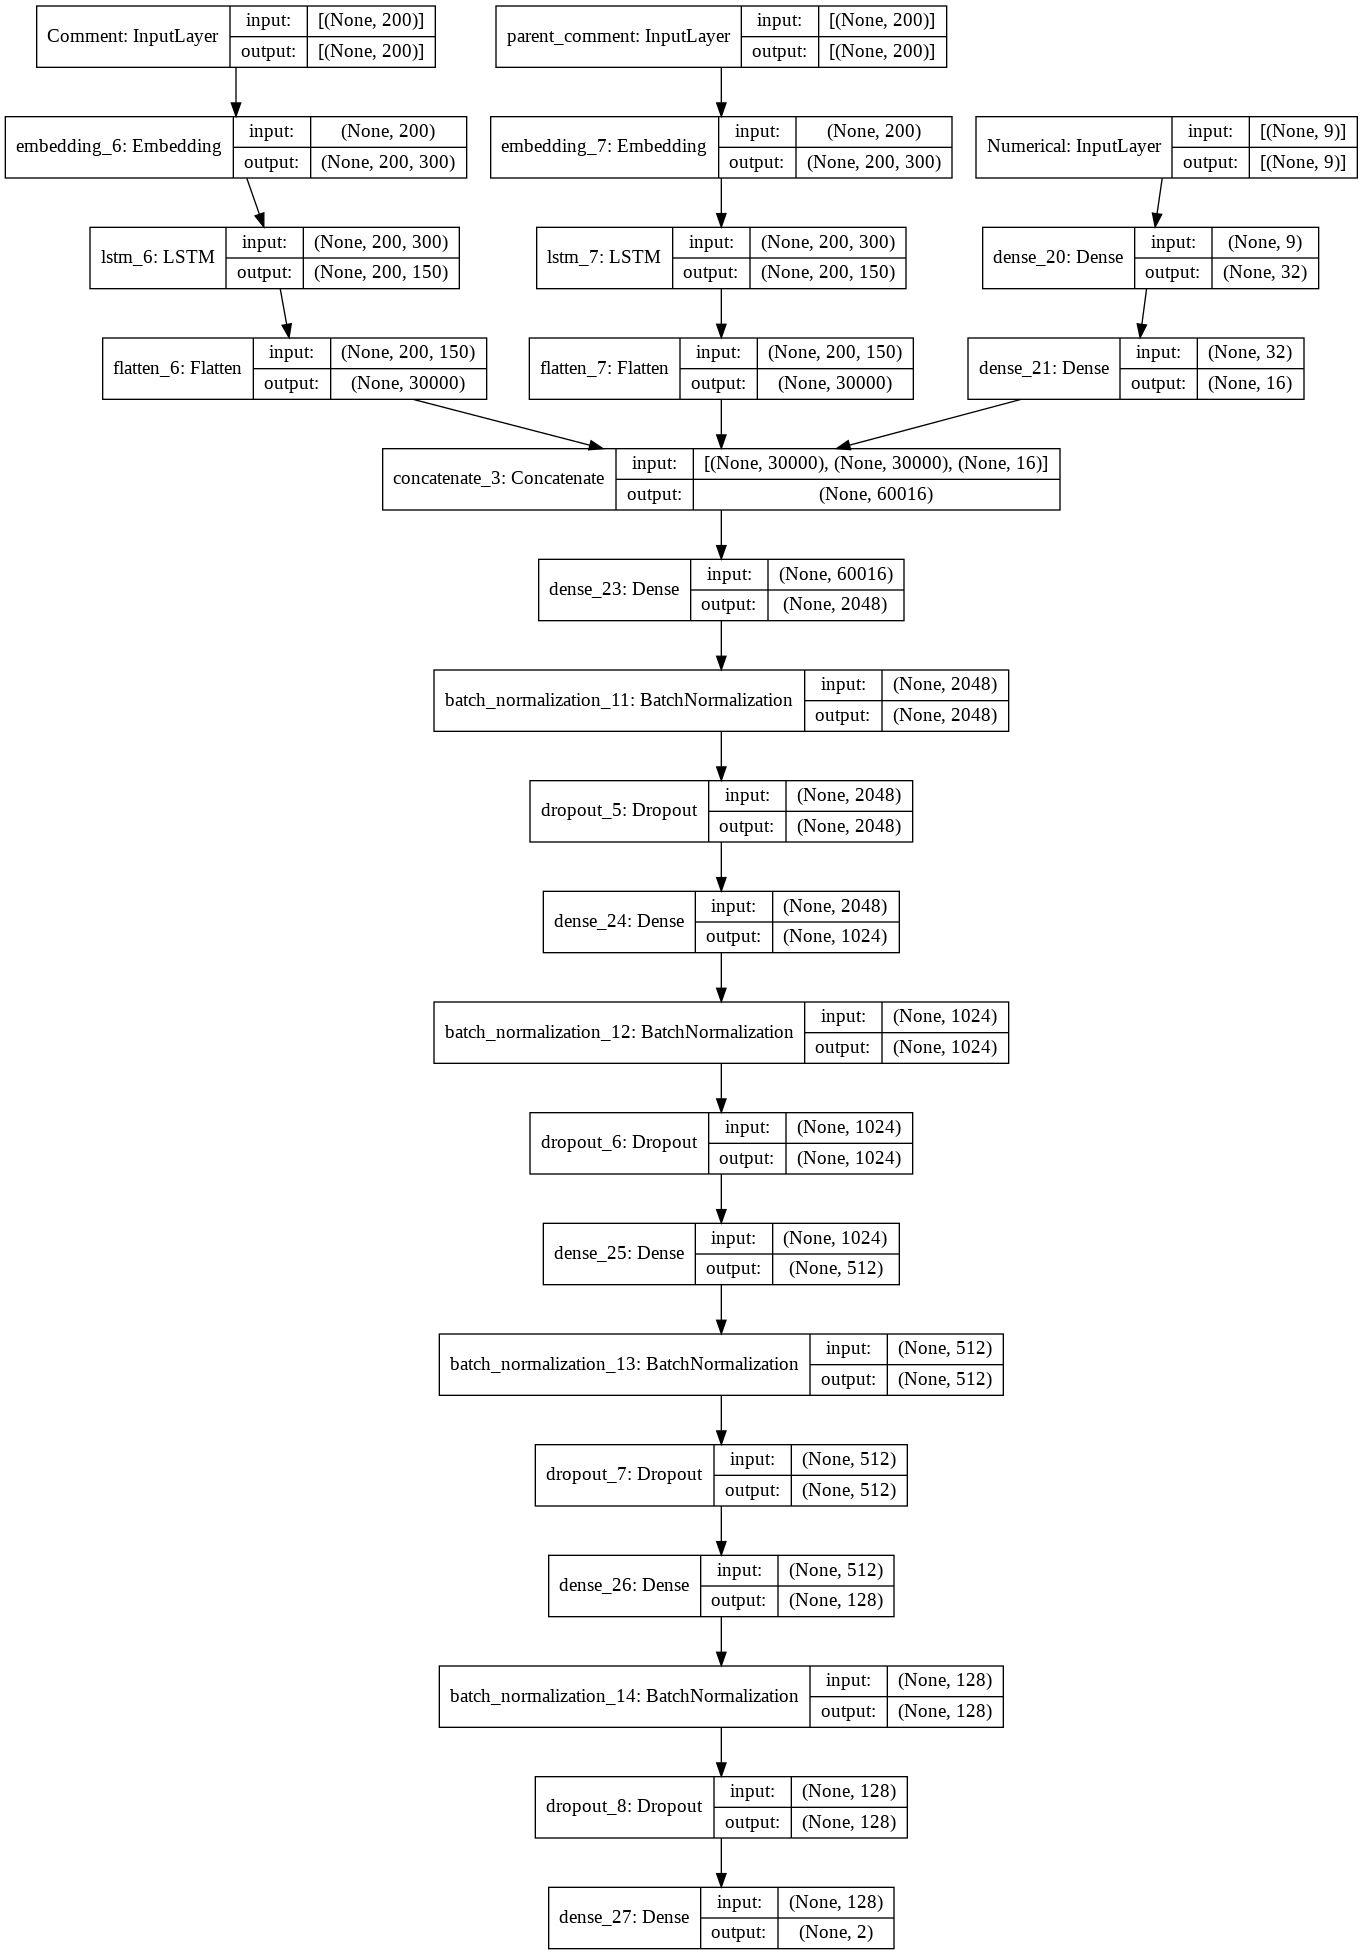

In [76]:
tf.keras.utils.plot_model(
    model3, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB')

In [70]:
from tensorflow.keras.callbacks import *
import os
filepath="weights_5.best.hdf1"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, mode='max')
earlystop = EarlyStopping(monitor = 'val_accuracy',  mode="max",min_delta = 0, patience = 3,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.25, patience = 2, verbose = 1)
%reload_ext tensorboard
import datetime
logdir = os.path.join("logs_5", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
tensorboard = TensorBoard(log_dir=logdir, histogram_freq=0, write_graph=True, write_grads=False, write_images=False)
callbacks = [checkpoint,reduce_lr,tensorboard,earlystop]

In [71]:
import tensorflow as tf
adam = tf.keras.optimizers.Adam(lr=0.01)
model3.compile(optimizer=adam, loss='categorical_crossentropy',metrics=['accuracy'])

In [72]:
hitory3=model3.fit(x=X_train,y=y_train,epochs=50,batch_size=512,validation_data=(X_test, y_test),callbacks=callbacks)

Epoch 1/50
1382/1382 [==============================] - 272s 194ms/step - loss: 6.4076 - accuracy: 0.6684 - val_loss: 3.3528 - val_accuracy: 0.6181

Epoch 00001: saving model to weights_5.best.hdf1


INFO:tensorflow:Assets written to: weights_5.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_5.best.hdf1/assets


Epoch 2/50
1382/1382 [==============================] - 267s 193ms/step - loss: 3.2257 - accuracy: 0.7016 - val_loss: 3.9244 - val_accuracy: 0.7168

Epoch 00002: saving model to weights_5.best.hdf1


INFO:tensorflow:Assets written to: weights_5.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_5.best.hdf1/assets


Epoch 3/50
1382/1382 [==============================] - 268s 194ms/step - loss: 3.1305 - accuracy: 0.7110 - val_loss: 3.7444 - val_accuracy: 0.5167

Epoch 00003: saving model to weights_5.best.hdf1


INFO:tensorflow:Assets written to: weights_5.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_5.best.hdf1/assets


Epoch 4/50
1382/1382 [==============================] - 267s 193ms/step - loss: 2.9363 - accuracy: 0.7167 - val_loss: 4.7037 - val_accuracy: 0.5000

Epoch 00004: saving model to weights_5.best.hdf1


INFO:tensorflow:Assets written to: weights_5.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_5.best.hdf1/assets



Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
Epoch 5/50
1382/1382 [==============================] - 267s 193ms/step - loss: 1.1363 - accuracy: 0.7283 - val_loss: 1.1711 - val_accuracy: 0.7175

Epoch 00005: saving model to weights_5.best.hdf1


INFO:tensorflow:Assets written to: weights_5.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_5.best.hdf1/assets


Epoch 6/50
1382/1382 [==============================] - 267s 193ms/step - loss: 1.1387 - accuracy: 0.7327 - val_loss: 1.3470 - val_accuracy: 0.6062

Epoch 00006: saving model to weights_5.best.hdf1


INFO:tensorflow:Assets written to: weights_5.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_5.best.hdf1/assets


Epoch 7/50
1382/1382 [==============================] - 268s 194ms/step - loss: 1.1176 - accuracy: 0.7362 - val_loss: 1.0975 - val_accuracy: 0.7260

Epoch 00007: saving model to weights_5.best.hdf1


INFO:tensorflow:Assets written to: weights_5.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_5.best.hdf1/assets


Epoch 8/50
1382/1382 [==============================] - 267s 193ms/step - loss: 1.1016 - accuracy: 0.7390 - val_loss: 1.1415 - val_accuracy: 0.6884

Epoch 00008: saving model to weights_5.best.hdf1


INFO:tensorflow:Assets written to: weights_5.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_5.best.hdf1/assets


Epoch 9/50
1382/1382 [==============================] - 267s 193ms/step - loss: 1.0773 - accuracy: 0.7419 - val_loss: 1.2641 - val_accuracy: 0.6622

Epoch 00009: saving model to weights_5.best.hdf1


INFO:tensorflow:Assets written to: weights_5.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_5.best.hdf1/assets



Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.
Epoch 10/50
1382/1382 [==============================] - 267s 193ms/step - loss: 0.6587 - accuracy: 0.7476 - val_loss: 0.9971 - val_accuracy: 0.6461

Epoch 00010: saving model to weights_5.best.hdf1


INFO:tensorflow:Assets written to: weights_5.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_5.best.hdf1/assets


Epoch 00010: early stopping


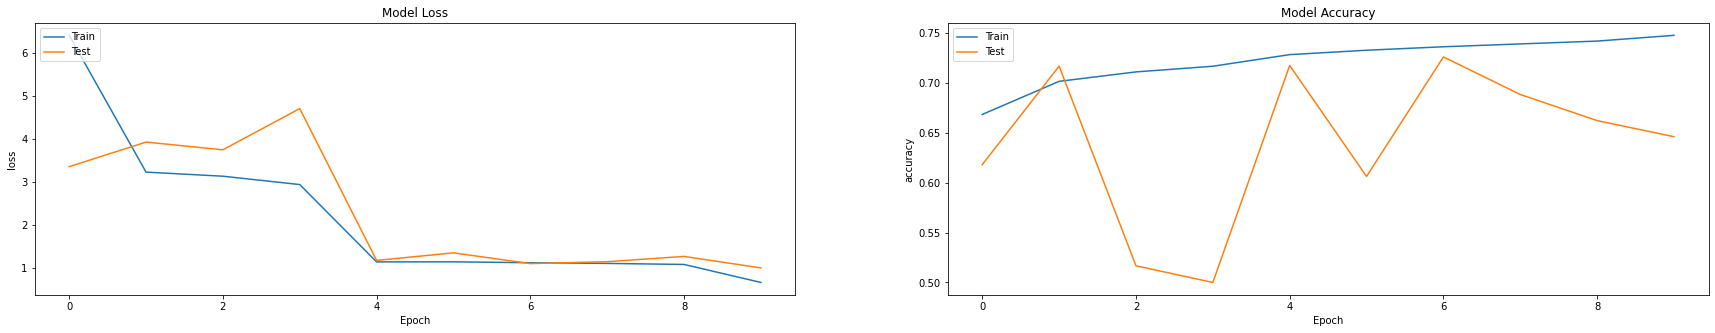

In [73]:
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(hitory3.history['loss'])
plt.plot(hitory3.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation f1_score
plt.subplot(122)
plt.plot(hitory3.history['accuracy'])
plt.plot(hitory3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# **Model:-4**

In [74]:
from tensorflow.keras.layers import concatenate,GRU
def GRU_Model(comm_len,token_com,par_comm_len,token_par):
    drop_lstm = 0.25
    drop_dense = 0.25
    num_lstm=150
  
    input_text_1=Input(shape=(comm_len,), name='Comment', dtype='float32')
    sequence_input_1=Embedding(len(token_com.word_index) + 1,300,weights=[embedding_comm],input_length=comm_len,trainable=False,dtype=tf.float32)(input_text_1)
    sequence_input_1=GRU(units=250, return_sequences=True,activation='tanh')(sequence_input_1)
    sequence_input_1=GRU(units=250, return_sequences=True,activation='tanh')(sequence_input_1)
    sequence_input_1=Flatten()(sequence_input_1)
    
    input_text_2=Input(shape=(par_comm_len,),name='parent_comment', dtype='float32')
    sequence_input_2=Embedding(len(token_par.word_index) + 1,300,weights=[embedding_P_comm],input_length=par_comm_len,trainable=False,dtype=tf.float32)(input_text_2)
    sequence_input_2=GRU(units=250, return_sequences=True,activation='tanh')(sequence_input_2)
    sequence_input_2=GRU(units=250, return_sequences=True,activation='tanh')(sequence_input_2)
    sequence_input_2=Flatten()(sequence_input_2)
    
    
    input5 = Input(shape=(9,),name='Numerical', dtype='float32')
    flatten_6 = Dense(32,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001),dtype=tf.float32)(input5)
    flatten_6 = Dense(16,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001),dtype=tf.float32)(flatten_6)
    concat=concatenate([sequence_input_1,sequence_input_2,flatten_6],dtype=tf.float32)
  
    y = Dense(128,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(concat)
    y = BatchNormalization()(y)
    y = Dense(64,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(y)
    y = BatchNormalization()(y)
    y = Dense(32,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(y)
  
    final_output=Dense(2,activation='softmax')(y)
  
    model= Model(inputs=[input_text_1,input_text_2,input5],outputs=final_output)
    return model

In [75]:
model1=GRU_Model(comm_len,token_com,par_comm_len,token_par)
model1.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Comment (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
parent_comment (InputLayer)     [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 200, 300)     108750000   Comment[0][0]                    
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 200, 300)     56921100    parent_comment[0][0]             
____________________________________________________________________________________________

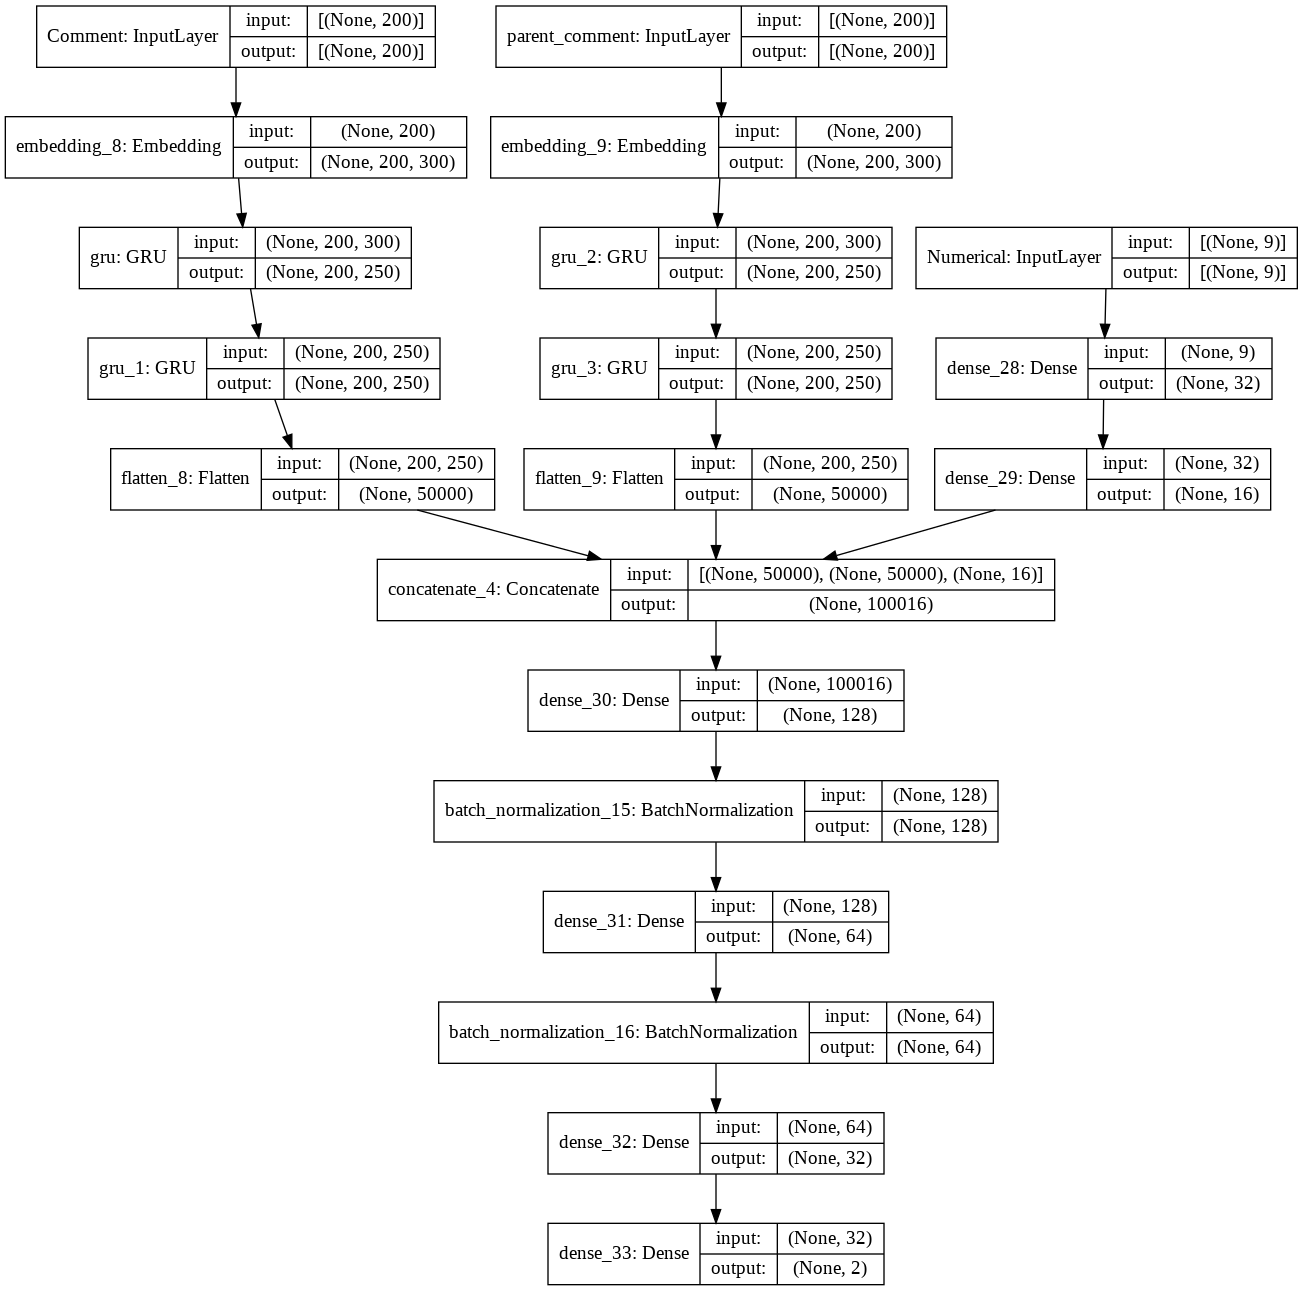

In [77]:
tf.keras.utils.plot_model(
    model1, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB')

In [78]:
from tensorflow.keras.callbacks import *
import os
filepath="weights_1.best.hdf1"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, mode='max')
earlystop = EarlyStopping(monitor = 'val_accuracy',  mode="max",min_delta = 0, patience = 3,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.25, patience = 2, verbose = 1)
%reload_ext tensorboard
import datetime
logdir = os.path.join("logs_1", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
tensorboard = TensorBoard(log_dir=logdir, histogram_freq=0, write_graph=True, write_grads=False, write_images=False)
callbacks = [checkpoint,reduce_lr,tensorboard,earlystop]

In [79]:
import tensorflow as tf
adam = tf.keras.optimizers.Adam(lr=0.01)
model1.compile(optimizer=adam, loss='categorical_crossentropy',metrics=['accuracy'])

In [80]:
hitory1=model1.fit(x=X_train,y=y_train,epochs=50,batch_size=512,validation_data=(X_test, y_test),callbacks=callbacks)

Epoch 1/50
1382/1382 [==============================] - 470s 336ms/step - loss: 2.5851 - accuracy: 0.6194 - val_loss: 11.5158 - val_accuracy: 0.5000

Epoch 00001: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 2/50
1382/1382 [==============================] - 461s 334ms/step - loss: 2.8827 - accuracy: 0.6375 - val_loss: 11.6437 - val_accuracy: 0.5003

Epoch 00002: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 3/50
1382/1382 [==============================] - 464s 336ms/step - loss: 2.4438 - accuracy: 0.6425 - val_loss: 1.7443 - val_accuracy: 0.5000

Epoch 00003: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 4/50
1382/1382 [==============================] - 462s 334ms/step - loss: 1.9135 - accuracy: 0.6518 - val_loss: 1.4876 - val_accuracy: 0.5000

Epoch 00004: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
Epoch 5/50
1382/1382 [==============================] - 461s 334ms/step - loss: 0.7150 - accuracy: 0.6712 - val_loss: 0.9826 - val_accuracy: 0.5000

Epoch 00005: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 00005: early stopping


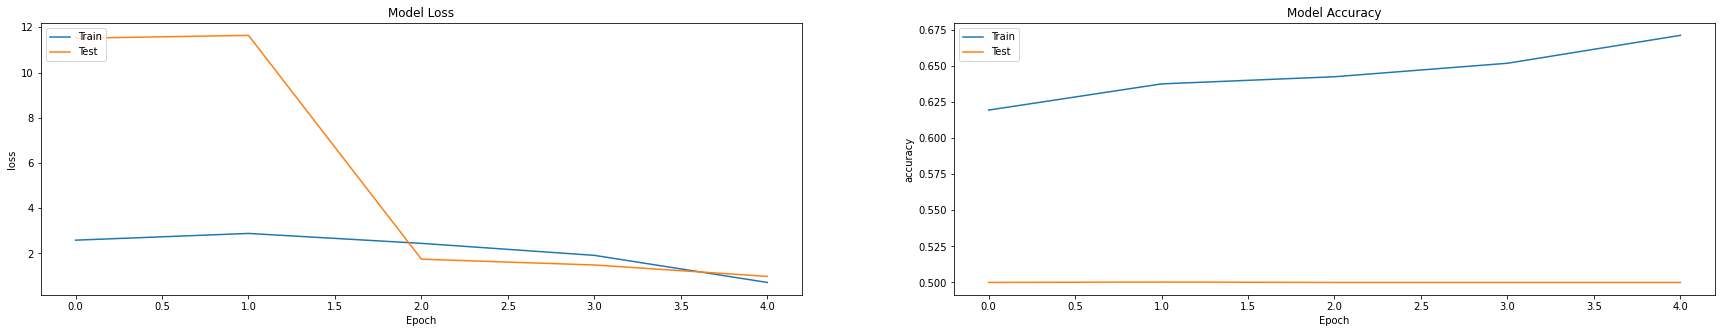

In [81]:
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(hitory1.history['loss'])
plt.plot(hitory1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation f1_score
plt.subplot(122)
plt.plot(hitory1.history['accuracy'])
plt.plot(hitory1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# **Model:-5**

In [49]:
from tensorflow.keras.layers import concatenate,GRU
def GRU_Model_1(comm_len,token_com,par_comm_len,token_par):
    drop_lstm = 0.25
    drop_dense = 0.25
    num_lstm=150
  
    input_text_1=Input(shape=(comm_len,), name='Comment', dtype='float32')
    sequence_input_1=Embedding(len(token_com.word_index) + 1,300,weights=[embedding_comm],input_length=comm_len,trainable=False,dtype=tf.float32)(input_text_1)
    sequence_input_1=GRU(units=250, return_sequences=True,activation='tanh')(sequence_input_1)
    sequence_input_1=GRU(units=250, return_sequences=True,activation='tanh')(sequence_input_1)
    sequence_input_1=Flatten()(sequence_input_1)
    
    input_text_2=Input(shape=(par_comm_len,),name='parent_comment', dtype='float32')
    sequence_input_2=Embedding(len(token_par.word_index) + 1,300,weights=[embedding_P_comm],input_length=par_comm_len,trainable=False,dtype=tf.float32)(input_text_2)
    sequence_input_2=GRU(units=250, return_sequences=True,activation='tanh')(sequence_input_2)
    sequence_input_2=GRU(units=250, return_sequences=True,activation='tanh')(sequence_input_2)
    sequence_input_2=Flatten()(sequence_input_2)
    
    
    input5 = Input(shape=(9,),name='Numerical', dtype='float32')
    flatten_6 = Dense(32,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001),dtype=tf.float32)(input5)
    flatten_6 = Dense(16,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001),dtype=tf.float32)(flatten_6)
    concat=concatenate([sequence_input_1,sequence_input_2,flatten_6],dtype=tf.float32)
  
    y = Dense(2048,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(concat)
    y = BatchNormalization()(y)
    y=Dropout(0.60)(y)
    y = Dense(1024,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(y)
    y = BatchNormalization()(y)
    y=Dropout(0.40)(y)
    y = Dense(512,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(y)
    y = BatchNormalization()(y)
    y=Dropout(0.30)(y)
    y = Dense(128,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(y)
    y = BatchNormalization()(y)
    y=Dropout(0.20)(y)
    final_output=Dense(2,activation='softmax')(y)
  
  
    model= Model(inputs=[input_text_1,input_text_2,input5],outputs=final_output)
    return model

In [50]:
model=GRU_Model_1(comm_len,token_com,par_comm_len,token_par)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Comment (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
parent_comment (InputLayer)     [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 200, 300)     108750000   Comment[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 200, 300)     56921100    parent_comment[0][0]             
____________________________________________________________________________________________

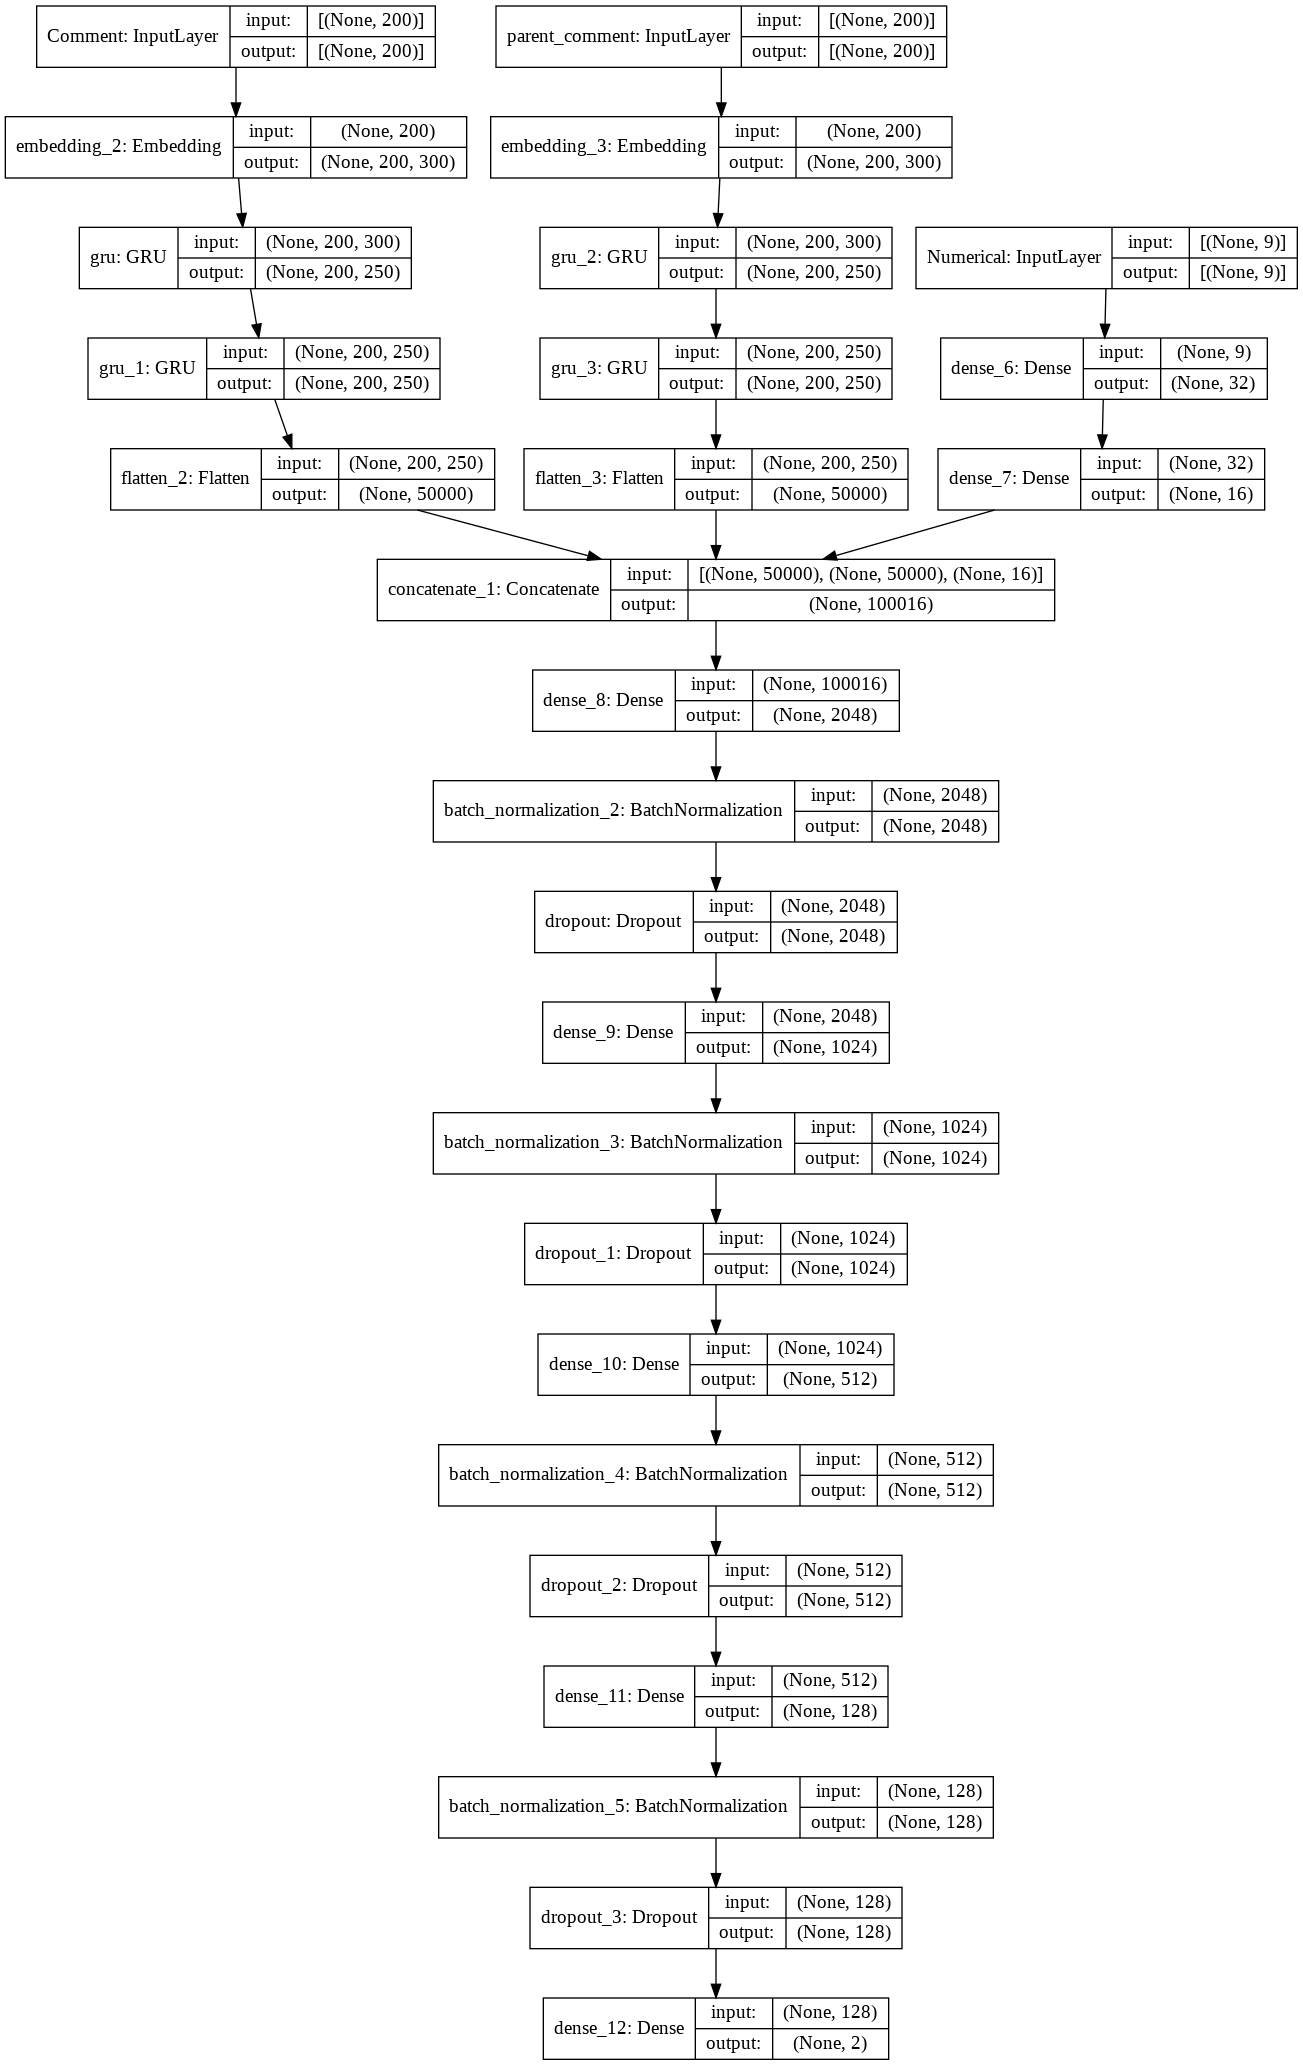

In [51]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB')

In [52]:
from tensorflow.keras.callbacks import *
import os
filepath="weights_1.best.hdf1"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, mode='max')
earlystop = EarlyStopping(monitor = 'val_accuracy',  mode="max",min_delta = 0, patience = 5,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.25, patience = 2, verbose = 1)
%reload_ext tensorboard
import datetime
logdir = os.path.join("logs_1", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
tensorboard = TensorBoard(log_dir=logdir, histogram_freq=0, write_graph=True, write_grads=False, write_images=False)
callbacks = [checkpoint,reduce_lr,tensorboard,earlystop]

In [53]:
import tensorflow as tf
adam = tf.keras.optimizers.Adam(lr=0.01)
model.compile(optimizer=adam, loss='categorical_crossentropy',metrics=['accuracy'])

In [54]:
hitory1=model.fit(x=X_train,y=y_train,epochs=50,batch_size=512,validation_data=(X_test, y_test),callbacks=callbacks)

Epoch 1/50
1382/1382 [==============================] - 1023s 736ms/step - loss: 11.4951 - accuracy: 0.6022 - val_loss: 20.2913 - val_accuracy: 0.5005

Epoch 00001: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 2/50
1382/1382 [==============================] - 1004s 727ms/step - loss: 7.9206 - accuracy: 0.6235 - val_loss: 42.9872 - val_accuracy: 0.5000

Epoch 00002: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 3/50
1382/1382 [==============================] - 996s 720ms/step - loss: 7.0449 - accuracy: 0.6253 - val_loss: 9.0613 - val_accuracy: 0.5000

Epoch 00003: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
Epoch 4/50
1382/1382 [==============================] - 992s 718ms/step - loss: 2.3765 - accuracy: 0.6407 - val_loss: 3.8371 - val_accuracy: 0.5000

Epoch 00004: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 5/50
1382/1382 [==============================] - 1010s 731ms/step - loss: 2.6376 - accuracy: 0.6487 - val_loss: 8.2843 - val_accuracy: 0.5000

Epoch 00005: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.
Epoch 6/50
1382/1382 [==============================] - 994s 720ms/step - loss: 1.1369 - accuracy: 0.6629 - val_loss: 1.7349 - val_accuracy: 0.5000

Epoch 00006: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 00006: early stopping


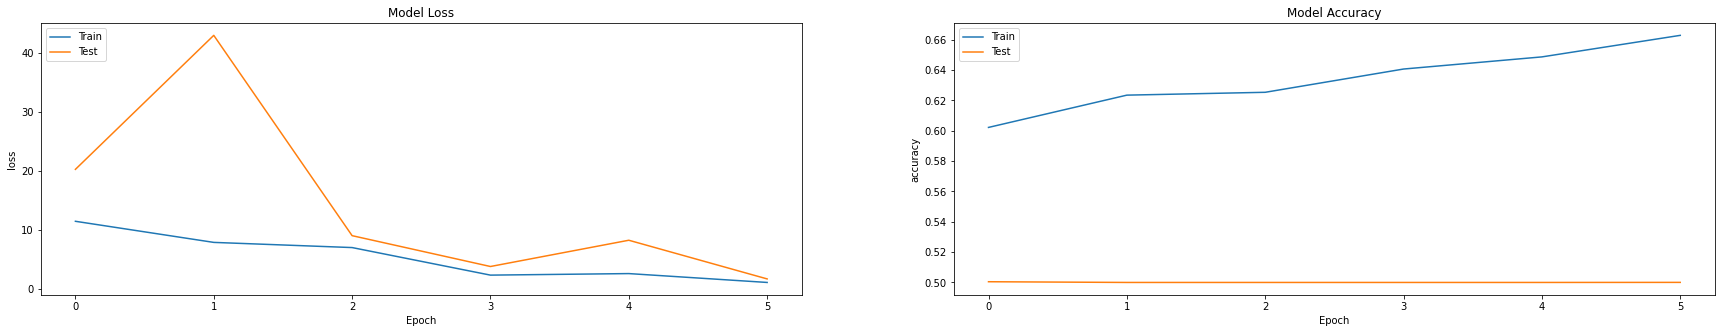

In [55]:
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(hitory1.history['loss'])
plt.plot(hitory1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation f1_score
plt.subplot(122)
plt.plot(hitory1.history['accuracy'])
plt.plot(hitory1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# **Model:-6**

In [42]:
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.layers import concatenate
def Bi_LSTM_Model(comm_len,token_com,par_comm_len,token_par):
    drop_lstm = 0.25
    drop_dense = 0.25
    num_lstm=150
  
    input_text_1=Input(shape=(comm_len,), name='Comment', dtype='float32')
    sequence_input_1=Embedding(len(token_com.word_index) + 1,300,weights=[embedding_comm],input_length=comm_len,trainable=False,dtype=tf.float32)(input_text_1)
    sequence_input_1=Bidirectional(LSTM(num_lstm,dropout=drop_lstm,return_sequences=True,dtype=tf.float32))(sequence_input_1)
    sequence_input_1=Flatten()(sequence_input_1)
    
    input_text_2=Input(shape=(par_comm_len,),name='parent_comment', dtype='float32')
    sequence_input_2=Embedding(len(token_par.word_index) + 1,300,weights=[embedding_P_comm],input_length=par_comm_len,trainable=False,dtype=tf.float32)(input_text_2)
    sequence_input_2=Bidirectional(LSTM(num_lstm,dropout=drop_lstm,return_sequences=True,dtype=tf.float32))(sequence_input_2)
    sequence_input_2=Flatten()(sequence_input_2)
    
    
    input5 = Input(shape=(9,),name='Numerical', dtype='float32')
    flatten_6 = Dense(32,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001),dtype=tf.float32)(input5)
    flatten_6 = Dense(16,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001),dtype=tf.float32)(flatten_6)
    concat=concatenate([sequence_input_1,sequence_input_2,flatten_6],dtype=tf.float32)
  
    y = Dense(128,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(concat)
    y = BatchNormalization()(y)
    y = Dense(64,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(y)
    y = BatchNormalization()(y)
    y = Dense(32,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(y)
  
    final_output=Dense(2,activation='softmax')(y)
  
    model= Model(inputs=[input_text_1,input_text_2,input5],outputs=final_output)
    return model

In [43]:
model1=Bi_LSTM_Model(comm_len,token_com,par_comm_len,token_par)
model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Comment (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
parent_comment (InputLayer)     [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 300)     108750000   Comment[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 300)     56921100    parent_comment[0][0]             
______________________________________________________________________________________________

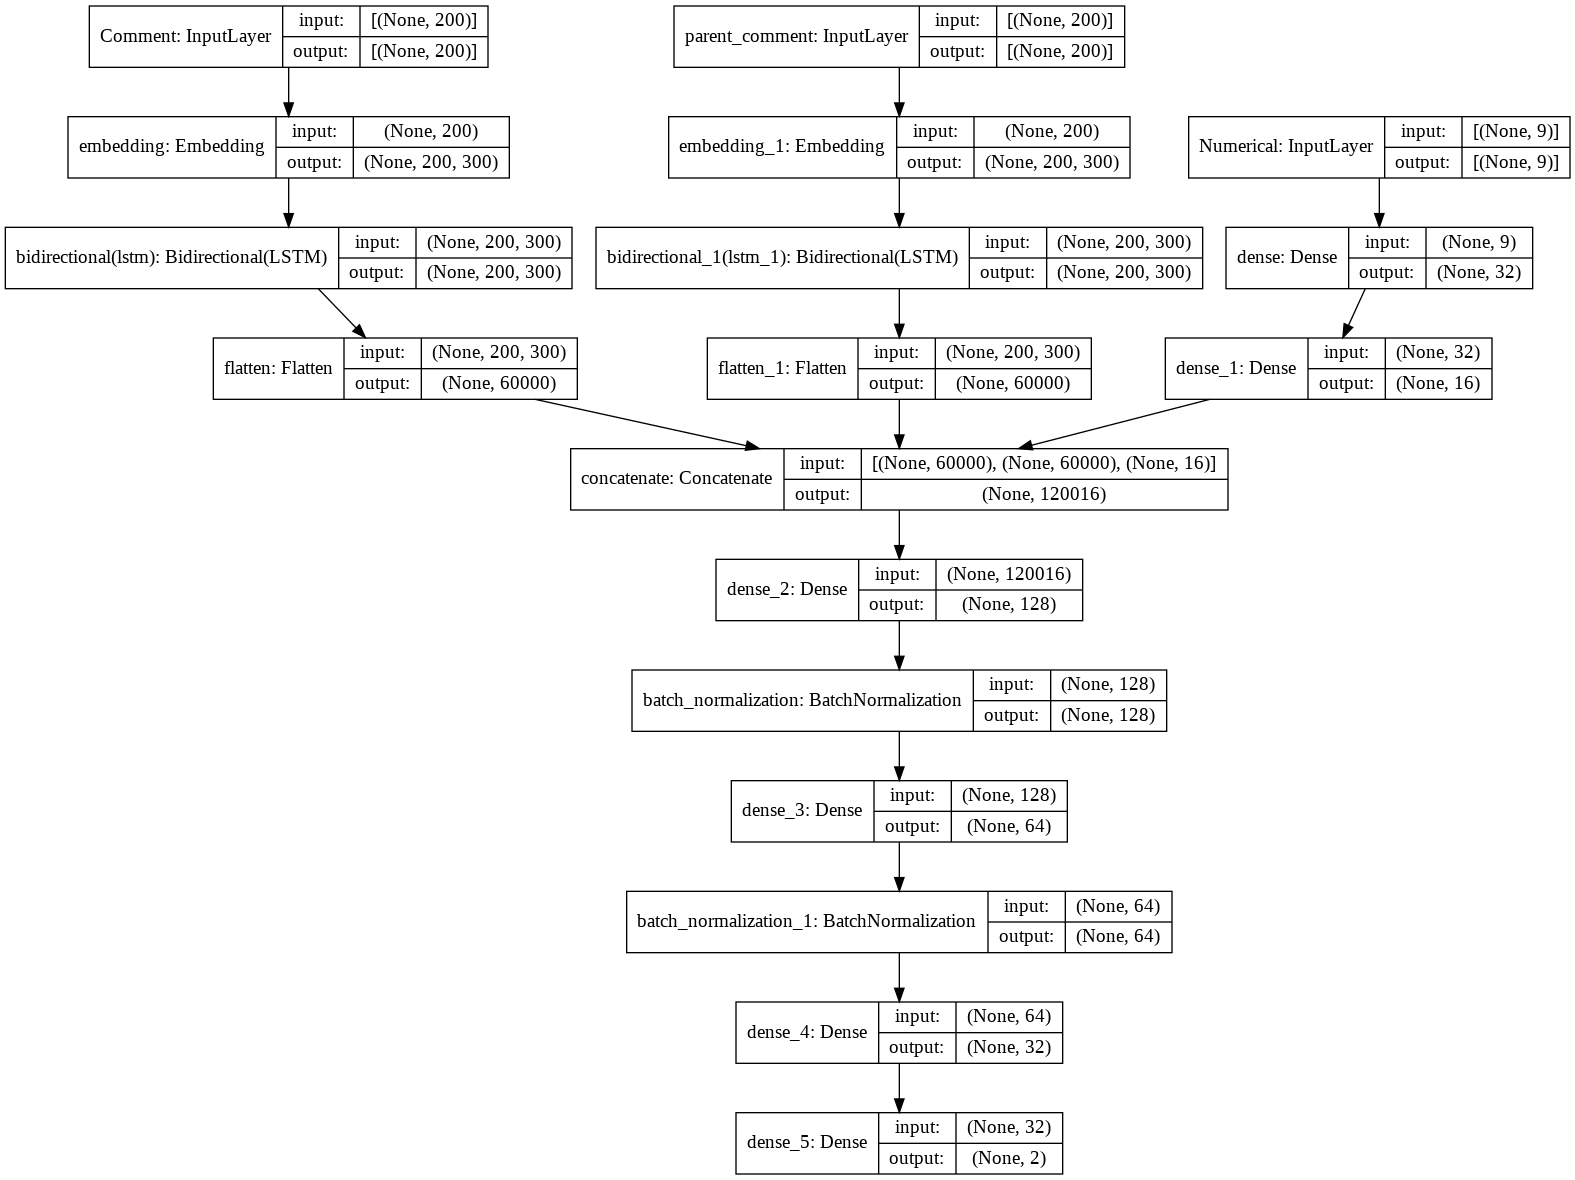

In [44]:
tf.keras.utils.plot_model(
    model1, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB')

In [45]:
from tensorflow.keras.callbacks import *
import os
filepath="weights_1.best.hdf1"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, mode='max')
earlystop = EarlyStopping(monitor = 'val_accuracy',  mode="max",min_delta = 0, patience = 3,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.25, patience = 2, verbose = 1)
%reload_ext tensorboard
import datetime
logdir = os.path.join("logs_1", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
tensorboard = TensorBoard(log_dir=logdir, histogram_freq=0, write_graph=True, write_grads=False, write_images=False)
callbacks = [checkpoint,reduce_lr,tensorboard,earlystop]

In [46]:
import tensorflow as tf
adam = tf.keras.optimizers.Adam(lr=0.01)
model1.compile(optimizer=adam, loss='categorical_crossentropy',metrics=['accuracy'])

In [47]:
hitory1=model1.fit(x=X_train,y=y_train,epochs=50,batch_size=512,validation_data=(X_test, y_test),callbacks=callbacks)

Epoch 1/50
1382/1382 [==============================] - 532s 379ms/step - loss: 2.4296 - accuracy: 0.6767 - val_loss: 4.1784 - val_accuracy: 0.5000

Epoch 00001: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 2/50
1382/1382 [==============================] - 525s 380ms/step - loss: 1.5588 - accuracy: 0.7055 - val_loss: 15.4845 - val_accuracy: 0.5000

Epoch 00002: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 3/50
1382/1382 [==============================] - 527s 381ms/step - loss: 1.3405 - accuracy: 0.7120 - val_loss: 1.7326 - val_accuracy: 0.5000

Epoch 00003: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets



Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
Epoch 4/50
1382/1382 [==============================] - 525s 380ms/step - loss: 0.5755 - accuracy: 0.7266 - val_loss: 2.4040 - val_accuracy: 0.5000

Epoch 00004: saving model to weights_1.best.hdf1


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets


Epoch 00004: early stopping


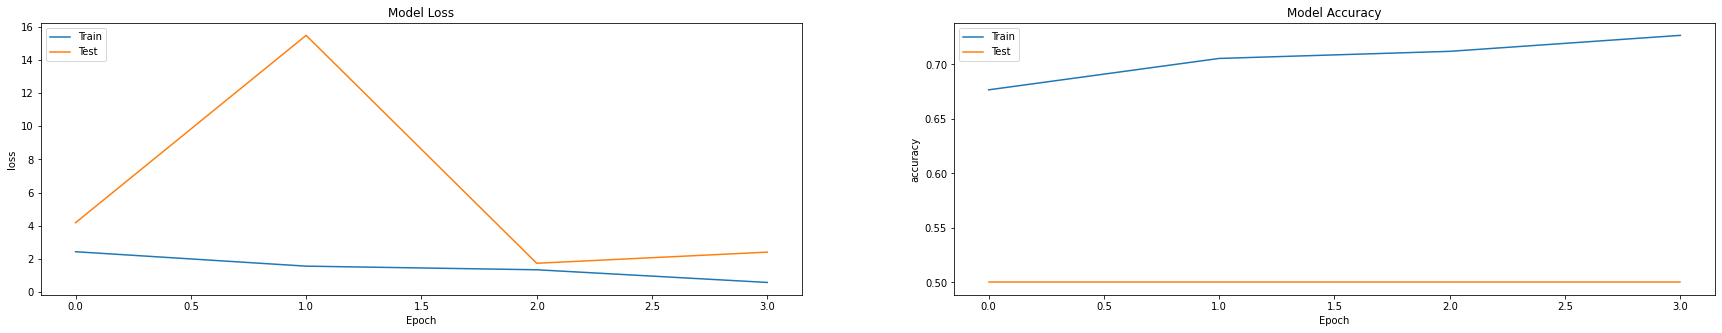

In [48]:
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(hitory1.history['loss'])
plt.plot(hitory1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation f1_score
plt.subplot(122)
plt.plot(hitory1.history['accuracy'])
plt.plot(hitory1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()